In [1]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler , QuantileTransformer , normalize
from sklearn.metrics import r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras import metrics, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
epochs = 1000
tester_units = [0]
shared_units = Volume_units = ema6_units = ema12_units = ema26_units = macd_units = wrsi_units = K_units = D_units = closed_units = 64
batch_size = 256
early_stop = EarlyStopping(monitor='val_dense_9_loss', patience=20)
model_cp = ModelCheckpoint("model_units_"+str(shared_units)+"batch_"+str(batch_size)+".cp",monitor='dense_9_loss',save_best_only=True)
def splitData(X,Y,rate,data_date=[]):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:-1]
    if len(data_date!=0):
        dates_train = data_date[:int(X.shape[0]*rate)]
        dates_val = data_date[int(X.shape[0]*rate):]
        return X_train, Y_train, X_val, Y_val, dates_train,dates_val
    return X_train, Y_train, X_val, Y_val

df = pd.read_csv("data/2317_indicators.csv")
#print(df)
mms = QuantileTransformer()
sc_data = mms.fit_transform(df.drop('date',axis=1).values)
#X_train = df.values
X_train = sc_data
#y_train = df.loc[1:].values
y_train = sc_data[1:]
X_train , Y_train , X_val , Y_val, dates_tran, dates_val = splitData(X_train,y_train,0.8,df.iloc[:,[0]].values)

X_train_df = pd.DataFrame(data=X_train)
X_val_df = pd.DataFrame(data=X_val)

shared_lstm_init = LSTM(shared_units,activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer = regularizers.l2(0.01),return_sequences = True)
shared_lstm1 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm2 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm3 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=False)

Normalization

In [3]:
"""
sc_X = QuantileTransformer()
X_train_sc = sc_X.fit_transform(X_train)
print(X_train.shape)
X_val_sc = sc_X.transform(X_val)
X_train_df = pd.DataFrame(data=X_train_sc)
X_val_df = pd.DataFrame(data=X_val_sc)
sc = MinMaxScaler(feature_range=(np.min(df.loc[:,'closed'].values),np.max(df.loc[:,'closed'].values)))
a = np.array(X_train_df.loc[:,1].values)
a = a.reshape(a.shape[0],1)
b = np.array(X_val_df.loc[:,1].values)
b = b.reshape(b.shape[0],1)
a = sc.fit_transform(a)
b = sc.transform(b)"""

"\nsc_X = QuantileTransformer()\nX_train_sc = sc_X.fit_transform(X_train)\nprint(X_train.shape)\nX_val_sc = sc_X.transform(X_val)\nX_train_df = pd.DataFrame(data=X_train_sc)\nX_val_df = pd.DataFrame(data=X_val_sc)\nsc = MinMaxScaler(feature_range=(np.min(df.loc[:,'closed'].values),np.max(df.loc[:,'closed'].values)))\na = np.array(X_train_df.loc[:,1].values)\na = a.reshape(a.shape[0],1)\nb = np.array(X_val_df.loc[:,1].values)\nb = b.reshape(b.shape[0],1)\na = sc.fit_transform(a)\nb = sc.transform(b)"

Layer#1 Volume Training

In [4]:
#Volume_X_train = a.reshape(a.shape[0])
Volume_X_train = X_train_df.loc[:,1].values
Volume_Y_train = Volume_X_train[1:]
Volume_X_train = Volume_X_train[:-1]
#Volume_X_val = b.reshape(b.shape[0])
Volume_X_val = X_val_df.loc[:,1].values
Volume_Y_val = Volume_X_val[1:]
Volume_X_val = Volume_X_val[:-1]
Volume_X_train = Volume_X_train.reshape(Volume_X_train.shape[0],1,1)
Volume_X_val = Volume_X_val.reshape(Volume_X_val.shape[0],1,1)
VolumeInput = Input(shape=(1,1))
Volume_model = shared_lstm_init(VolumeInput)
Volume_model = shared_lstm1(Volume_model)
Volume_model = shared_lstm2(Volume_model)
Volume_out = shared_lstm3(Volume_model)
Volume_model = Dense(1)(Volume_out)

Layer#2 ema6

In [5]:
ema6_X_train = X_train_df.loc[:,2].values 
ema6_Y_train = ema6_X_train[1:] 
ema6_X_train = ema6_X_train[:-1]
ema6_X_val = X_val_df.loc[:,2].values
ema6_Y_val = ema6_X_val[1:]
ema6_X_val = ema6_X_val[:-1]
ema6_X_train = ema6_X_train.reshape(ema6_X_train.shape[0],1,1)
ema6_X_val = ema6_X_val.reshape(ema6_X_val.shape[0],1,1)
ema6Input = Input(shape=(1,1))
ema6_model = shared_lstm_init(ema6Input)
ema6_model = shared_lstm1(ema6_model)
ema6_model = shared_lstm2(ema6_model)
ema6_out = shared_lstm3(ema6_model)
ema6_model = Dense(1)(ema6_out)

In [6]:
"""
model = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])
model.compile(loss = 'mean_squared_error',optimizer='Adam')
model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
preds = model.predict([Volume_X_val,ema6_X_val])
r2score = r2_score(Volume_Y_val,preds[0])
plt.plot(preds[0][:100])
plt.plot(Volume_Y_val[:100])
plt.show()
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
"""

'\nmodel = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])\nmodel.compile(loss = \'mean_squared_error\',optimizer=\'Adam\')\nmodel.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\n#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\npreds = model.predict([Volume_X_val,ema6_X_val])\nr2score = r2_score(Volume_Y_val,preds[0])\nplt.plot(preds[0][:100])\nplt.plot(Volume_Y_val[:100])\nplt.show()\nprint("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))\n'

Layer#2 ema12

In [7]:
ema12_X_train = X_train_df.loc[:,3].values
ema12_Y_train = ema12_X_train[1:] 
ema12_X_train = ema12_X_train[:-1]
ema12_X_val = X_val_df.loc[:,3].values 
ema12_Y_val = ema12_X_val[1:]
ema12_X_val = ema12_X_val[:-1]
ema12_X_train = ema12_X_train.reshape(ema12_X_train.shape[0],1,1)
ema12_X_val = ema12_X_val.reshape(ema12_X_val.shape[0],1,1)
ema12Input = Input(shape=(1,1))
ema12_model = shared_lstm_init(ema12Input)
ema12_model = shared_lstm1(ema12_model)
ema12_model = shared_lstm2(ema12_model)
ema12_out = shared_lstm3(ema12_model)
ema12_model = Dense(1,activation='relu')(ema12_out)
print(ema12_X_val.shape,ema12_Y_val.shape)

(463, 1, 1) (463,)


In [8]:
ema26_X_train = X_train_df.loc[:,4].values 
ema26_Y_train = ema26_X_train[1:] 
ema26_X_train = ema26_X_train[:-1]
ema26_X_val = X_val_df.loc[:,4].values
ema26_Y_val = ema26_X_val[1:]
ema26_X_val = ema26_X_val[:-1]
ema26_X_train = ema26_X_train.reshape(ema26_X_train.shape[0],1,1)
ema26_X_val = ema26_X_val.reshape(ema26_X_val.shape[0],1,1)
ema26Input = Input(shape=(1,1))
ema26_model = shared_lstm_init(ema26Input)
ema26_model = shared_lstm1(ema26_model)
ema26_model = shared_lstm2(ema26_model)
ema26_out = shared_lstm3(ema26_model)
ema26_model = Dense(1,activation='relu')(ema26_out)
print(ema26_X_val.shape,ema26_Y_val.shape)

(463, 1, 1) (463,)


In [9]:
macd_X_train = X_train_df.loc[:,5].values 
macd_Y_train = macd_X_train[1:] 
macd_X_train = macd_X_train[:-1]
macd_X_val = X_val_df.loc[:,5].values 
macd_Y_val = macd_X_val[1:]
macd_X_val = macd_X_val[:-1]
macd_X_train = macd_X_train.reshape(macd_X_train.shape[0],1,1)
macd_X_val = macd_X_val.reshape(macd_X_val.shape[0],1,1)
macdInput = Input(shape=(1,1))
macd_model = shared_lstm_init(macdInput)
macd_model = shared_lstm1(macd_model)
macd_model = shared_lstm2(macd_model)
macd_out = shared_lstm3(macd_model)
macd_model = Dense(1,activation='relu')(macd_out)

In [10]:
wrsi_X_train = X_train_df.loc[:,6].values 
wrsi_Y_train = wrsi_X_train[1:] 
wrsi_X_train = wrsi_X_train[:-1]
wrsi_X_val = X_val_df.loc[:,6].values 
wrsi_Y_val = wrsi_X_val[1:]
wrsi_X_val = wrsi_X_val[:-1]
wrsi_X_train = wrsi_X_train.reshape(wrsi_X_train.shape[0],1,1)
wrsi_X_val = wrsi_X_val.reshape(wrsi_X_val.shape[0],1,1)
wrsiInput = Input(shape=(1,1))
wrsi_model = shared_lstm_init(wrsiInput)
wrsi_model = shared_lstm1(wrsi_model)
wrsi_model = shared_lstm2(wrsi_model)
wrsi_out = shared_lstm3(wrsi_model)
wrsi_model = Dense(1,activation='relu')(wrsi_out)
print(wrsi_X_val.shape,wrsi_Y_val.shape)

(463, 1, 1) (463,)


In [11]:
K_X_train = X_train_df.loc[:,7].values
K_Y_train = K_X_train[1:] 
K_X_train = K_X_train[:-1]
K_X_val = X_val_df.loc[:,7].values
K_Y_val = K_X_val[1:]
K_X_val = K_X_val[:-1]
K_X_train = K_X_train.reshape(K_X_train.shape[0],1,1)
K_X_val = K_X_val.reshape(K_X_val.shape[0],1,1)
KInput = Input(shape=(1,1))
K_model = shared_lstm_init(KInput)
K_model = shared_lstm1(K_model)
K_model = shared_lstm2(K_model)
K_out = shared_lstm3(K_model)
K_model = Dense(1,activation='relu')(K_out)
print(K_X_val.shape,K_Y_val.shape)

(463, 1, 1) (463,)


In [12]:
D_X_train = X_train_df.loc[:,8].values
D_Y_train = D_X_train[1:] 
D_X_train = D_X_train[:-1]
D_X_val = X_val_df.loc[:,8].values 
D_Y_val = D_X_val[1:]
D_X_val = D_X_val[:-1]
D_X_train = D_X_train.reshape(D_X_train.shape[0],1,1)
D_X_val = D_X_val.reshape(D_X_val.shape[0],1,1)
DInput = Input(shape=(1,1))
D_model = shared_lstm_init(DInput)
D_model = shared_lstm1(D_model)
D_model = shared_lstm2(D_model)
D_out = shared_lstm3(D_model)
D_model = Dense(1,activation='relu')(D_out)
print(D_X_val.shape,D_Y_val.shape)

(463, 1, 1) (463,)


In [13]:
closed_X_train = X_train_df.loc[:,0].values 
closed_Y_train = closed_X_train[1:] 
closed_X_train = closed_X_train[:-1]
closed_X_val = X_val_df.loc[:,0].values 
closed_Y_val = closed_X_val[1:]
closed_X_val = closed_X_val[:-1]
closed_X_train = closed_X_train.reshape(closed_X_train.shape[0],1,1)
closed_X_val = closed_X_val.reshape(closed_X_val.shape[0],1,1)
closedInput = Input(shape=(1,1))
#closed_model = Concatenate([Volume_out,ema6_out,ema12_out,ema26_out,macd_out,wrsi_out,K_out,D_out,closedInput])
closed_model = shared_lstm_init(closedInput)
closed_model = shared_lstm1(closed_model)
closed_model = shared_lstm2(closed_model)
closed_out = shared_lstm3(closed_model)
closed_model = Dense(1,activation='relu')(closed_out)
inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput]
outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model]
shared_units = 64
merged_model = Model(inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput],outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model])
merged_model.summary()
merged_model.compile(loss='mean_squared_error',optimizer='Adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_5 (I

In [14]:

history = merged_model.fit([Volume_X_train,ema6_X_train,ema12_X_train,ema26_X_train,macd_X_train,wrsi_X_train,K_X_train,D_X_train,closed_X_train],[Volume_Y_train,ema6_Y_train,ema12_Y_train,ema26_Y_train,macd_Y_train,wrsi_Y_train,K_Y_train,D_Y_train,closed_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,validation_data=([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val],[Volume_Y_val,ema6_Y_val,ema12_Y_val,ema26_Y_val,macd_Y_val,wrsi_Y_val,K_Y_val,D_Y_val,closed_Y_val]),callbacks=[early_stop,model_cp])

Train on 1851 samples, validate on 463 samples
Epoch 1/1000
1851/1851 [==============================] - 37s 20ms/step - loss: 8.4415 - dense_1_loss: 0.3162 - dense_2_loss: 0.3724 - dense_3_loss: 0.3689 - dense_4_loss: 0.3687 - dense_5_loss: 0.3604 - dense_6_loss: 0.3421 - dense_7_loss: 0.3506 - dense_8_loss: 0.3551 - dense_9_loss: 0.3768 - val_loss: 6.8472 - val_dense_1_loss: 0.3705 - val_dense_2_loss: 0.1469 - val_dense_3_loss: 0.1479 - val_dense_4_loss: 0.1590 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.2582 - val_dense_7_loss: 0.2396 - val_dense_8_loss: 0.2302 - val_dense_9_loss: 0.1484
Epoch 2/1000
1851/1851 [==============================] - 1s 509us/step - loss: 7.8170 - dense_1_loss: 0.3047 - dense_2_loss: 0.3548 - dense_3_loss: 0.3480 - dense_4_loss: 0.3523 - dense_5_loss: 0.3604 - dense_6_loss: 0.3236 - dense_7_loss: 0.3365 - dense_8_loss: 0.3414 - dense_9_loss: 0.3664 - val_loss: 6.2726 - val_dense_1_loss: 0.3559 - val_dense_2_loss: 0.1368 - val_dense_3_loss: 0.1359 - v

Epoch 16/1000
1851/1851 [==============================] - 1s 421us/step - loss: 2.8770 - dense_1_loss: 0.0629 - dense_2_loss: 0.0278 - dense_3_loss: 0.0285 - dense_4_loss: 0.0295 - dense_5_loss: 0.3604 - dense_6_loss: 0.0435 - dense_7_loss: 0.0351 - dense_8_loss: 0.0334 - dense_9_loss: 0.0295 - val_loss: 2.8172 - val_dense_1_loss: 0.0609 - val_dense_2_loss: 0.0511 - val_dense_3_loss: 0.0524 - val_dense_4_loss: 0.0522 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0468 - val_dense_7_loss: 0.0418 - val_dense_8_loss: 0.0405 - val_dense_9_loss: 0.0544
Epoch 17/1000
1851/1851 [==============================] - 1s 423us/step - loss: 2.8143 - dense_1_loss: 0.0624 - dense_2_loss: 0.0265 - dense_3_loss: 0.0270 - dense_4_loss: 0.0281 - dense_5_loss: 0.3604 - dense_6_loss: 0.0421 - dense_7_loss: 0.0336 - dense_8_loss: 0.0317 - dense_9_loss: 0.0283 - val_loss: 2.7574 - val_dense_1_loss: 0.0599 - val_dense_2_loss: 0.0492 - val_dense_3_loss: 0.0506 - val_dense_4_loss: 0.0504 - val_dense_5_loss: 0

Epoch 31/1000
1851/1851 [==============================] - 1s 430us/step - loss: 2.2669 - dense_1_loss: 0.0598 - dense_2_loss: 0.0095 - dense_3_loss: 0.0090 - dense_4_loss: 0.0102 - dense_5_loss: 0.3604 - dense_6_loss: 0.0304 - dense_7_loss: 0.0165 - dense_8_loss: 0.0130 - dense_9_loss: 0.0118 - val_loss: 2.1612 - val_dense_1_loss: 0.0564 - val_dense_2_loss: 0.0193 - val_dense_3_loss: 0.0182 - val_dense_4_loss: 0.0199 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0197 - val_dense_8_loss: 0.0168 - val_dense_9_loss: 0.0238
Epoch 32/1000
1851/1851 [==============================] - 1s 449us/step - loss: 2.2387 - dense_1_loss: 0.0598 - dense_2_loss: 0.0087 - dense_3_loss: 0.0083 - dense_4_loss: 0.0094 - dense_5_loss: 0.3604 - dense_6_loss: 0.0300 - dense_7_loss: 0.0157 - dense_8_loss: 0.0122 - dense_9_loss: 0.0111 - val_loss: 2.1298 - val_dense_1_loss: 0.0564 - val_dense_2_loss: 0.0179 - val_dense_3_loss: 0.0168 - val_dense_4_loss: 0.0184 - val_dense_5_loss: 0

1851/1851 [==============================] - 1s 429us/step - loss: 1.9282 - dense_1_loss: 0.0603 - dense_2_loss: 0.0043 - dense_3_loss: 0.0037 - dense_4_loss: 0.0046 - dense_5_loss: 0.3604 - dense_6_loss: 0.0282 - dense_7_loss: 0.0114 - dense_8_loss: 0.0069 - dense_9_loss: 0.0063 - val_loss: 1.7986 - val_dense_1_loss: 0.0565 - val_dense_2_loss: 0.0090 - val_dense_3_loss: 0.0077 - val_dense_4_loss: 0.0092 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0266 - val_dense_7_loss: 0.0128 - val_dense_8_loss: 0.0088 - val_dense_9_loss: 0.0131
Epoch 46/1000
1851/1851 [==============================] - 1s 417us/step - loss: 1.9074 - dense_1_loss: 0.0603 - dense_2_loss: 0.0042 - dense_3_loss: 0.0036 - dense_4_loss: 0.0044 - dense_5_loss: 0.3604 - dense_6_loss: 0.0281 - dense_7_loss: 0.0112 - dense_8_loss: 0.0068 - dense_9_loss: 0.0061 - val_loss: 1.7773 - val_dense_1_loss: 0.0565 - val_dense_2_loss: 0.0087 - val_dense_3_loss: 0.0075 - val_dense_4_loss: 0.0089 - val_dense_5_loss: 0.2258 - val_de

Epoch 60/1000
1851/1851 [==============================] - 1s 420us/step - loss: 1.6479 - dense_1_loss: 0.0601 - dense_2_loss: 0.0032 - dense_3_loss: 0.0027 - dense_4_loss: 0.0033 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0104 - dense_8_loss: 0.0056 - dense_9_loss: 0.0049 - val_loss: 1.5141 - val_dense_1_loss: 0.0562 - val_dense_2_loss: 0.0067 - val_dense_3_loss: 0.0055 - val_dense_4_loss: 0.0067 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0262 - val_dense_7_loss: 0.0114 - val_dense_8_loss: 0.0069 - val_dense_9_loss: 0.0103
Epoch 61/1000
1851/1851 [==============================] - 1s 433us/step - loss: 1.6313 - dense_1_loss: 0.0601 - dense_2_loss: 0.0031 - dense_3_loss: 0.0026 - dense_4_loss: 0.0033 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0104 - dense_8_loss: 0.0056 - dense_9_loss: 0.0049 - val_loss: 1.4974 - val_dense_1_loss: 0.0562 - val_dense_2_loss: 0.0066 - val_dense_3_loss: 0.0054 - val_dense_4_loss: 0.0066 - val_dense_5_loss: 0

Epoch 75/1000
1851/1851 [==============================] - 1s 429us/step - loss: 1.4222 - dense_1_loss: 0.0599 - dense_2_loss: 0.0026 - dense_3_loss: 0.0022 - dense_4_loss: 0.0027 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0100 - dense_8_loss: 0.0051 - dense_9_loss: 0.0041 - val_loss: 1.2868 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0054 - val_dense_3_loss: 0.0044 - val_dense_4_loss: 0.0053 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0107 - val_dense_8_loss: 0.0060 - val_dense_9_loss: 0.0086
Epoch 76/1000
1851/1851 [==============================] - 1s 444us/step - loss: 1.4088 - dense_1_loss: 0.0599 - dense_2_loss: 0.0026 - dense_3_loss: 0.0021 - dense_4_loss: 0.0026 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0100 - dense_8_loss: 0.0050 - dense_9_loss: 0.0041 - val_loss: 1.2733 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0053 - val_dense_3_loss: 0.0043 - val_dense_4_loss: 0.0052 - val_dense_5_loss: 0

Epoch 90/1000
1851/1851 [==============================] - 1s 427us/step - loss: 1.2389 - dense_1_loss: 0.0599 - dense_2_loss: 0.0022 - dense_3_loss: 0.0018 - dense_4_loss: 0.0022 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0098 - dense_8_loss: 0.0048 - dense_9_loss: 0.0035 - val_loss: 1.1021 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0035 - val_dense_4_loss: 0.0042 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0055 - val_dense_9_loss: 0.0072
Epoch 91/1000
1851/1851 [==============================] - 1s 447us/step - loss: 1.2279 - dense_1_loss: 0.0599 - dense_2_loss: 0.0022 - dense_3_loss: 0.0018 - dense_4_loss: 0.0021 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0098 - dense_8_loss: 0.0048 - dense_9_loss: 0.0035 - val_loss: 1.0911 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0035 - val_dense_4_loss: 0.0041 - val_dense_5_loss: 0

Epoch 105/1000
1851/1851 [==============================] - 1s 424us/step - loss: 1.0894 - dense_1_loss: 0.0599 - dense_2_loss: 0.0019 - dense_3_loss: 0.0015 - dense_4_loss: 0.0018 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0097 - dense_8_loss: 0.0046 - dense_9_loss: 0.0030 - val_loss: 0.9514 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0036 - val_dense_3_loss: 0.0028 - val_dense_4_loss: 0.0033 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0102 - val_dense_8_loss: 0.0052 - val_dense_9_loss: 0.0060
Epoch 106/1000
1851/1851 [==============================] - 1s 421us/step - loss: 1.0804 - dense_1_loss: 0.0599 - dense_2_loss: 0.0019 - dense_3_loss: 0.0015 - dense_4_loss: 0.0018 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0097 - dense_8_loss: 0.0046 - dense_9_loss: 0.0030 - val_loss: 0.9424 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0035 - val_dense_3_loss: 0.0028 - val_dense_4_loss: 0.0032 - val_dense_5_loss:

Epoch 120/1000
1851/1851 [==============================] - 1s 477us/step - loss: 0.9674 - dense_1_loss: 0.0600 - dense_2_loss: 0.0016 - dense_3_loss: 0.0013 - dense_4_loss: 0.0015 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0096 - dense_8_loss: 0.0045 - dense_9_loss: 0.0026 - val_loss: 0.8285 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0029 - val_dense_3_loss: 0.0022 - val_dense_4_loss: 0.0026 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0100 - val_dense_8_loss: 0.0050 - val_dense_9_loss: 0.0050
Epoch 121/1000
1851/1851 [==============================] - 1s 455us/step - loss: 0.9601 - dense_1_loss: 0.0600 - dense_2_loss: 0.0016 - dense_3_loss: 0.0013 - dense_4_loss: 0.0015 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0096 - dense_8_loss: 0.0045 - dense_9_loss: 0.0026 - val_loss: 0.8211 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0028 - val_dense_3_loss: 0.0022 - val_dense_4_loss: 0.0025 - val_dense_5_loss:

Epoch 135/1000
1851/1851 [==============================] - 1s 418us/step - loss: 0.8677 - dense_1_loss: 0.0601 - dense_2_loss: 0.0014 - dense_3_loss: 0.0011 - dense_4_loss: 0.0013 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 0.0023 - val_loss: 0.7280 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0017 - val_dense_4_loss: 0.0020 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0042
Epoch 136/1000
1851/1851 [==============================] - 1s 421us/step - loss: 0.8617 - dense_1_loss: 0.0601 - dense_2_loss: 0.0014 - dense_3_loss: 0.0011 - dense_4_loss: 0.0013 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0023 - val_loss: 0.7220 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0017 - val_dense_4_loss: 0.0020 - val_dense_5_loss:

Epoch 150/1000
1851/1851 [==============================] - 1s 427us/step - loss: 0.7858 - dense_1_loss: 0.0601 - dense_2_loss: 0.0012 - dense_3_loss: 0.0010 - dense_4_loss: 0.0011 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0021 - val_loss: 0.6455 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0019 - val_dense_3_loss: 0.0014 - val_dense_4_loss: 0.0016 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0036
Epoch 151/1000
1851/1851 [==============================] - 1s 424us/step - loss: 0.7809 - dense_1_loss: 0.0601 - dense_2_loss: 0.0012 - dense_3_loss: 0.0010 - dense_4_loss: 0.0011 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0021 - val_loss: 0.6406 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0014 - val_dense_4_loss: 0.0016 - val_dense_5_loss:

Epoch 165/1000
1851/1851 [==============================] - 1s 429us/step - loss: 0.7185 - dense_1_loss: 0.0602 - dense_2_loss: 0.0011 - dense_3_loss: 9.3074e-04 - dense_4_loss: 9.8859e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0019 - val_loss: 0.5781 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0013 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0031
Epoch 166/1000
1851/1851 [==============================] - 1s 421us/step - loss: 0.7145 - dense_1_loss: 0.0602 - dense_2_loss: 0.0011 - dense_3_loss: 9.2717e-04 - dense_4_loss: 9.8306e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0019 - val_loss: 0.5741 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0013 - v

1851/1851 [==============================] - 1s 447us/step - loss: 0.6676 - dense_1_loss: 0.0603 - dense_2_loss: 0.0011 - dense_3_loss: 8.9438e-04 - dense_4_loss: 9.2789e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0018 - val_loss: 0.5276 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0029
Epoch 180/1000
1851/1851 [==============================] - 1s 442us/step - loss: 0.6644 - dense_1_loss: 0.0603 - dense_2_loss: 0.0011 - dense_3_loss: 8.9258e-04 - dense_4_loss: 9.2461e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0018 - val_loss: 0.5244 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_5_loss

1851/1851 [==============================] - 1s 461us/step - loss: 0.6276 - dense_1_loss: 0.0603 - dense_2_loss: 0.0010 - dense_3_loss: 8.7183e-04 - dense_4_loss: 8.8746e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 0.0017 - val_loss: 0.4881 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0028
Epoch 194/1000
1851/1851 [==============================] - 1s 444us/step - loss: 0.6251 - dense_1_loss: 0.0603 - dense_2_loss: 0.0010 - dense_3_loss: 8.7030e-04 - dense_4_loss: 8.8488e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 0.0017 - val_loss: 0.4857 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_5_loss

1851/1851 [==============================] - 1s 448us/step - loss: 0.5972 - dense_1_loss: 0.0602 - dense_2_loss: 9.8697e-04 - dense_3_loss: 8.5080e-04 - dense_4_loss: 8.5394e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 0.0016 - val_loss: 0.4581 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0027
Epoch 208/1000
1851/1851 [==============================] - 1s 426us/step - loss: 0.5953 - dense_1_loss: 0.0602 - dense_2_loss: 9.8480e-04 - dense_3_loss: 8.4935e-04 - dense_4_loss: 8.5178e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 0.0016 - val_loss: 0.4563 - val_dense_1_loss: 0.0561 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0011 - val_dens

1851/1851 [==============================] - 1s 431us/step - loss: 0.5743 - dense_1_loss: 0.0602 - dense_2_loss: 9.5999e-04 - dense_3_loss: 8.3180e-04 - dense_4_loss: 8.2645e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0096 - dense_8_loss: 0.0045 - dense_9_loss: 0.0016 - val_loss: 0.4354 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0010 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0026
Epoch 222/1000
1851/1851 [==============================] - 1s 460us/step - loss: 0.5729 - dense_1_loss: 0.0602 - dense_2_loss: 9.5829e-04 - dense_3_loss: 8.3052e-04 - dense_4_loss: 8.2467e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0096 - dense_8_loss: 0.0045 - dense_9_loss: 0.0016 - val_loss: 0.4340 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0010 - val_dense_4_loss: 0.0011 - val_dens

1851/1851 [==============================] - 1s 429us/step - loss: 0.5569 - dense_1_loss: 0.0602 - dense_2_loss: 9.3817e-04 - dense_3_loss: 8.1490e-04 - dense_4_loss: 8.0334e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0015 - val_loss: 0.4180 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 9.9508e-04 - val_dense_4_loss: 0.0010 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0025
Epoch 236/1000
1851/1851 [==============================] - 1s 420us/step - loss: 0.5558 - dense_1_loss: 0.0602 - dense_2_loss: 9.3674e-04 - dense_3_loss: 8.1376e-04 - dense_4_loss: 8.0181e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0015 - val_loss: 0.4169 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 9.9141e-04 - val_dense_4_loss: 0.0010 - 

1851/1851 [==============================] - 1s 443us/step - loss: 0.5434 - dense_1_loss: 0.0602 - dense_2_loss: 9.1955e-04 - dense_3_loss: 7.9976e-04 - dense_4_loss: 7.8319e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0015 - val_loss: 0.4044 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 9.4224e-04 - val_dense_4_loss: 9.4744e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0049 - val_dense_9_loss: 0.0024
Epoch 250/1000
1851/1851 [==============================] - 1s 478us/step - loss: 0.5426 - dense_1_loss: 0.0602 - dense_2_loss: 9.1833e-04 - dense_3_loss: 7.9875e-04 - dense_4_loss: 7.8185e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0279 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0015 - val_loss: 0.4036 - val_dense_1_loss: 0.0559 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 9.3847e-04 - val_dense_4_loss: 9.429

1851/1851 [==============================] - 1s 425us/step - loss: 0.5329 - dense_1_loss: 0.0602 - dense_2_loss: 9.0357e-04 - dense_3_loss: 7.8650e-04 - dense_4_loss: 7.6561e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3938 - val_dense_1_loss: 0.0558 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 8.9138e-04 - val_dense_4_loss: 8.8734e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0023
Epoch 264/1000
1851/1851 [==============================] - 1s 446us/step - loss: 0.5322 - dense_1_loss: 0.0602 - dense_2_loss: 9.0253e-04 - dense_3_loss: 7.8563e-04 - dense_4_loss: 7.6446e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3931 - val_dense_1_loss: 0.0558 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 8.8794e-04 - val_dense_4_loss: 8.832

1851/1851 [==============================] - 1s 421us/step - loss: 0.5247 - dense_1_loss: 0.0602 - dense_2_loss: 8.9013e-04 - dense_3_loss: 7.7525e-04 - dense_4_loss: 7.5054e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3854 - val_dense_1_loss: 0.0558 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 8.4643e-04 - val_dense_4_loss: 8.3381e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0022
Epoch 278/1000
1851/1851 [==============================] - 1s 435us/step - loss: 0.5242 - dense_1_loss: 0.0602 - dense_2_loss: 8.8926e-04 - dense_3_loss: 7.7452e-04 - dense_4_loss: 7.4956e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3849 - val_dense_1_loss: 0.0558 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 8.4350e-04 - val_dense_4_loss: 8.302

1851/1851 [==============================] - 1s 421us/step - loss: 0.5183 - dense_1_loss: 0.0601 - dense_2_loss: 8.8314e-04 - dense_3_loss: 7.6987e-04 - dense_4_loss: 7.4207e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3791 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 8.3480e-04 - val_dense_4_loss: 8.1316e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0261 - val_dense_7_loss: 0.0099 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0021
Epoch 292/1000
1851/1851 [==============================] - 1s 451us/step - loss: 0.5180 - dense_1_loss: 0.0601 - dense_2_loss: 8.8425e-04 - dense_3_loss: 7.7103e-04 - dense_4_loss: 7.4341e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3787 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 8.3009e-04 - val_dense_4_loss: 8.077

1851/1851 [==============================] - 1s 413us/step - loss: 0.5137 - dense_1_loss: 0.0602 - dense_2_loss: 8.7401e-04 - dense_3_loss: 7.6150e-04 - dense_4_loss: 7.3141e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3742 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.9398e-04 - val_dense_3_loss: 7.8930e-04 - val_dense_4_loss: 7.6168e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0021
Epoch 306/1000
1851/1851 [==============================] - 1s 423us/step - loss: 0.5134 - dense_1_loss: 0.0602 - dense_2_loss: 8.7333e-04 - dense_3_loss: 7.6090e-04 - dense_4_loss: 7.3062e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3739 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.9091e-04 - val_dense_3_loss: 7.8676e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 428us/step - loss: 0.5099 - dense_1_loss: 0.0602 - dense_2_loss: 8.6546e-04 - dense_3_loss: 7.5394e-04 - dense_4_loss: 7.2140e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3703 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.5599e-04 - val_dense_3_loss: 7.5806e-04 - val_dense_4_loss: 7.2427e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0048 - val_dense_9_loss: 0.0020
Epoch 320/1000
1851/1851 [==============================] - 1s 417us/step - loss: 0.5097 - dense_1_loss: 0.0602 - dense_2_loss: 8.6492e-04 - dense_3_loss: 7.5346e-04 - dense_4_loss: 7.2076e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3701 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.5364e-04 - val_dense_3_loss: 7.5614e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 428us/step - loss: 0.5068 - dense_1_loss: 0.0602 - dense_2_loss: 8.5864e-04 - dense_3_loss: 7.4790e-04 - dense_4_loss: 7.1314e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3672 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.2653e-04 - val_dense_3_loss: 7.3395e-04 - val_dense_4_loss: 6.9392e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0019
Epoch 334/1000
1851/1851 [==============================] - 1s 424us/step - loss: 0.5067 - dense_1_loss: 0.0602 - dense_2_loss: 8.5821e-04 - dense_3_loss: 7.4751e-04 - dense_4_loss: 7.1260e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0014 - val_loss: 0.3669 - val_dense_1_loss: 0.0557 - val_dense_2_loss: 9.2468e-04 - val_dense_3_loss: 7.3244e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 435us/step - loss: 0.5043 - dense_1_loss: 0.0602 - dense_2_loss: 8.5311e-04 - dense_3_loss: 7.4295e-04 - dense_4_loss: 7.0618e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3645 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 9.0123e-04 - val_dense_3_loss: 7.1304e-04 - val_dense_4_loss: 6.6670e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0019
Epoch 348/1000
1851/1851 [==============================] - 1s 431us/step - loss: 0.5041 - dense_1_loss: 0.0602 - dense_2_loss: 8.5255e-04 - dense_3_loss: 7.4240e-04 - dense_4_loss: 7.0547e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3643 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 9.0176e-04 - val_dense_3_loss: 7.1370e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 430us/step - loss: 0.5024 - dense_1_loss: 0.0602 - dense_2_loss: 8.4603e-04 - dense_3_loss: 7.3588e-04 - dense_4_loss: 6.9774e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3625 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.6487e-04 - val_dense_3_loss: 6.8097e-04 - val_dense_4_loss: 6.3116e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0018
Epoch 362/1000
1851/1851 [==============================] - 1s 424us/step - loss: 0.5023 - dense_1_loss: 0.0602 - dense_2_loss: 8.4581e-04 - dense_3_loss: 7.3567e-04 - dense_4_loss: 6.9748e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3624 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.6258e-04 - val_dense_3_loss: 6.7899e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 421us/step - loss: 0.5010 - dense_1_loss: 0.0602 - dense_2_loss: 8.4174e-04 - dense_3_loss: 7.3201e-04 - dense_4_loss: 6.9291e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3610 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.4739e-04 - val_dense_3_loss: 6.6716e-04 - val_dense_4_loss: 6.1494e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0018
Epoch 376/1000
1851/1851 [==============================] - 1s 444us/step - loss: 0.5009 - dense_1_loss: 0.0602 - dense_2_loss: 8.4151e-04 - dense_3_loss: 7.3181e-04 - dense_4_loss: 6.9266e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3609 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.4653e-04 - val_dense_3_loss: 6.6652e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 447us/step - loss: 0.4997 - dense_1_loss: 0.0602 - dense_2_loss: 8.3884e-04 - dense_3_loss: 7.2944e-04 - dense_4_loss: 6.8957e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3597 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.3602e-04 - val_dense_3_loss: 6.5844e-04 - val_dense_4_loss: 6.0389e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0018
Epoch 390/1000
1851/1851 [==============================] - 1s 430us/step - loss: 0.4997 - dense_1_loss: 0.0602 - dense_2_loss: 8.3869e-04 - dense_3_loss: 7.2931e-04 - dense_4_loss: 6.8938e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3596 - val_dense_1_loss: 0.0556 - val_dense_2_loss: 8.3399e-04 - val_dense_3_loss: 6.5664e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 433us/step - loss: 0.4987 - dense_1_loss: 0.0602 - dense_2_loss: 8.3548e-04 - dense_3_loss: 7.2627e-04 - dense_4_loss: 6.8558e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3585 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.2110e-04 - val_dense_3_loss: 6.4590e-04 - val_dense_4_loss: 5.8906e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0017
Epoch 404/1000
1851/1851 [==============================] - 1s 429us/step - loss: 0.4986 - dense_1_loss: 0.0602 - dense_2_loss: 8.3534e-04 - dense_3_loss: 7.2615e-04 - dense_4_loss: 6.8542e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3585 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.2037e-04 - val_dense_3_loss: 6.4533e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 437us/step - loss: 0.4977 - dense_1_loss: 0.0602 - dense_2_loss: 8.3448e-04 - dense_3_loss: 7.2553e-04 - dense_4_loss: 6.8386e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3576 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.1197e-04 - val_dense_3_loss: 6.3935e-04 - val_dense_4_loss: 5.7725e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0017
Epoch 418/1000
1851/1851 [==============================] - 1s 431us/step - loss: 0.4977 - dense_1_loss: 0.0602 - dense_2_loss: 8.3386e-04 - dense_3_loss: 7.2489e-04 - dense_4_loss: 6.8289e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 0.0013 - val_loss: 0.3575 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.1213e-04 - val_dense_3_loss: 6.3970e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 450us/step - loss: 0.4970 - dense_1_loss: 0.0602 - dense_2_loss: 8.3161e-04 - dense_3_loss: 7.2266e-04 - dense_4_loss: 6.7896e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3567 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.0317e-04 - val_dense_3_loss: 6.3240e-04 - val_dense_4_loss: 5.5995e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0017
Epoch 432/1000
1851/1851 [==============================] - 1s 428us/step - loss: 0.4969 - dense_1_loss: 0.0602 - dense_2_loss: 8.3144e-04 - dense_3_loss: 7.2249e-04 - dense_4_loss: 6.7871e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3567 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 8.0245e-04 - val_dense_3_loss: 6.3184e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 442us/step - loss: 0.4963 - dense_1_loss: 0.0602 - dense_2_loss: 8.2936e-04 - dense_3_loss: 7.2056e-04 - dense_4_loss: 6.7572e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3560 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.9372e-04 - val_dense_3_loss: 6.2516e-04 - val_dense_4_loss: 5.4702e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0017
Epoch 446/1000
1851/1851 [==============================] - 1s 441us/step - loss: 0.4963 - dense_1_loss: 0.0602 - dense_2_loss: 8.2922e-04 - dense_3_loss: 7.2043e-04 - dense_4_loss: 6.7551e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3560 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.9309e-04 - val_dense_3_loss: 6.2468e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 447us/step - loss: 0.4957 - dense_1_loss: 0.0602 - dense_2_loss: 8.2745e-04 - dense_3_loss: 7.1882e-04 - dense_4_loss: 6.7308e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3553 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.8535e-04 - val_dense_3_loss: 6.1887e-04 - val_dense_4_loss: 5.3646e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 460/1000
1851/1851 [==============================] - 1s 433us/step - loss: 0.4956 - dense_1_loss: 0.0602 - dense_2_loss: 8.2732e-04 - dense_3_loss: 7.1870e-04 - dense_4_loss: 6.7291e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3553 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.8479e-04 - val_dense_3_loss: 6.1845e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 468us/step - loss: 0.4951 - dense_1_loss: 0.0602 - dense_2_loss: 8.2581e-04 - dense_3_loss: 7.1735e-04 - dense_4_loss: 6.7089e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3547 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.7796e-04 - val_dense_3_loss: 6.1343e-04 - val_dense_4_loss: 5.2757e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 474/1000
1851/1851 [==============================] - 1s 489us/step - loss: 0.4950 - dense_1_loss: 0.0602 - dense_2_loss: 8.2570e-04 - dense_3_loss: 7.1725e-04 - dense_4_loss: 6.7075e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3546 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.7746e-04 - val_dense_3_loss: 6.1307e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 569us/step - loss: 0.4945 - dense_1_loss: 0.0602 - dense_2_loss: 8.2442e-04 - dense_3_loss: 7.1613e-04 - dense_4_loss: 6.6906e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3541 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.7145e-04 - val_dense_3_loss: 6.0878e-04 - val_dense_4_loss: 5.1999e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 488/1000
1851/1851 [==============================] - 1s 491us/step - loss: 0.4945 - dense_1_loss: 0.0602 - dense_2_loss: 8.2433e-04 - dense_3_loss: 7.1605e-04 - dense_4_loss: 6.6894e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3540 - val_dense_1_loss: 0.0555 - val_dense_2_loss: 7.7103e-04 - val_dense_3_loss: 6.0848e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 464us/step - loss: 0.4940 - dense_1_loss: 0.0602 - dense_2_loss: 8.2325e-04 - dense_3_loss: 7.1513e-04 - dense_4_loss: 6.6753e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3535 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.6581e-04 - val_dense_3_loss: 6.0487e-04 - val_dense_4_loss: 5.1352e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 502/1000
1851/1851 [==============================] - 1s 442us/step - loss: 0.4939 - dense_1_loss: 0.0602 - dense_2_loss: 8.2318e-04 - dense_3_loss: 7.1507e-04 - dense_4_loss: 6.6743e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3535 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.6544e-04 - val_dense_3_loss: 6.0462e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 439us/step - loss: 0.4935 - dense_1_loss: 0.0602 - dense_2_loss: 8.2185e-04 - dense_3_loss: 7.1326e-04 - dense_4_loss: 6.6562e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3530 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.5928e-04 - val_dense_3_loss: 5.9535e-04 - val_dense_4_loss: 5.0515e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 516/1000
1851/1851 [==============================] - 1s 458us/step - loss: 0.4934 - dense_1_loss: 0.0602 - dense_2_loss: 8.2175e-04 - dense_3_loss: 7.1311e-04 - dense_4_loss: 6.6548e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3529 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.5884e-04 - val_dense_3_loss: 5.9459e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 684us/step - loss: 0.4930 - dense_1_loss: 0.0602 - dense_2_loss: 8.2032e-04 - dense_3_loss: 7.1125e-04 - dense_4_loss: 6.6360e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3525 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.5189e-04 - val_dense_3_loss: 5.8522e-04 - val_dense_4_loss: 4.9624e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 530/1000
1851/1851 [==============================] - 1s 645us/step - loss: 0.4930 - dense_1_loss: 0.0602 - dense_2_loss: 8.2022e-04 - dense_3_loss: 7.1113e-04 - dense_4_loss: 6.6347e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3524 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.5142e-04 - val_dense_3_loss: 5.8463e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 578us/step - loss: 0.4926 - dense_1_loss: 0.0602 - dense_2_loss: 8.1912e-04 - dense_3_loss: 7.0982e-04 - dense_4_loss: 6.6201e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3520 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.4613e-04 - val_dense_3_loss: 5.7820e-04 - val_dense_4_loss: 4.8926e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 544/1000
1851/1851 [==============================] - 1s 516us/step - loss: 0.4925 - dense_1_loss: 0.0602 - dense_2_loss: 8.1904e-04 - dense_3_loss: 7.0973e-04 - dense_4_loss: 6.6192e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3520 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.4578e-04 - val_dense_3_loss: 5.7779e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 504us/step - loss: 0.4921 - dense_1_loss: 0.0602 - dense_2_loss: 8.1821e-04 - dense_3_loss: 7.0880e-04 - dense_4_loss: 6.6082e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3516 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.4168e-04 - val_dense_3_loss: 5.7314e-04 - val_dense_4_loss: 4.8386e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 558/1000
1851/1851 [==============================] - 1s 515us/step - loss: 0.4921 - dense_1_loss: 0.0602 - dense_2_loss: 8.1816e-04 - dense_3_loss: 7.0874e-04 - dense_4_loss: 6.6075e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3515 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.4142e-04 - val_dense_3_loss: 5.7284e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 593us/step - loss: 0.4917 - dense_1_loss: 0.0602 - dense_2_loss: 8.1757e-04 - dense_3_loss: 7.0810e-04 - dense_4_loss: 6.5995e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3511 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3840e-04 - val_dense_3_loss: 5.6956e-04 - val_dense_4_loss: 4.7978e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 572/1000
1851/1851 [==============================] - 1s 543us/step - loss: 0.4917 - dense_1_loss: 0.0602 - dense_2_loss: 8.1753e-04 - dense_3_loss: 7.0806e-04 - dense_4_loss: 6.5990e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3511 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3820e-04 - val_dense_3_loss: 5.6935e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 624us/step - loss: 0.4913 - dense_1_loss: 0.0602 - dense_2_loss: 8.1716e-04 - dense_3_loss: 7.0766e-04 - dense_4_loss: 6.5937e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3507 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3614e-04 - val_dense_3_loss: 5.6719e-04 - val_dense_4_loss: 4.7683e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 586/1000
1851/1851 [==============================] - 1s 584us/step - loss: 0.4913 - dense_1_loss: 0.0602 - dense_2_loss: 8.1713e-04 - dense_3_loss: 7.0764e-04 - dense_4_loss: 6.5933e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3507 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3601e-04 - val_dense_3_loss: 5.6705e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 626us/step - loss: 0.4910 - dense_1_loss: 0.0602 - dense_2_loss: 8.1694e-04 - dense_3_loss: 7.0744e-04 - dense_4_loss: 6.5902e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3503 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3476e-04 - val_dense_3_loss: 5.6577e-04 - val_dense_4_loss: 4.7482e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 600/1000
1851/1851 [==============================] - 2s 832us/step - loss: 0.4909 - dense_1_loss: 0.0602 - dense_2_loss: 8.1693e-04 - dense_3_loss: 7.0743e-04 - dense_4_loss: 6.5900e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3503 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3470e-04 - val_dense_3_loss: 5.6571e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 665us/step - loss: 0.4906 - dense_1_loss: 0.0602 - dense_2_loss: 8.1689e-04 - dense_3_loss: 7.0741e-04 - dense_4_loss: 6.5886e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3500 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3414e-04 - val_dense_3_loss: 5.6516e-04 - val_dense_4_loss: 4.7360e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 614/1000
1851/1851 [==============================] - 1s 733us/step - loss: 0.4906 - dense_1_loss: 0.0602 - dense_2_loss: 8.1689e-04 - dense_3_loss: 7.0741e-04 - dense_4_loss: 6.5886e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3499 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3413e-04 - val_dense_3_loss: 5.6514e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 598us/step - loss: 0.4902 - dense_1_loss: 0.0602 - dense_2_loss: 8.1696e-04 - dense_3_loss: 7.0750e-04 - dense_4_loss: 6.5886e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3496 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3410e-04 - val_dense_3_loss: 5.6512e-04 - val_dense_4_loss: 4.7298e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 628/1000
1851/1851 [==============================] - 1s 619us/step - loss: 0.4902 - dense_1_loss: 0.0602 - dense_2_loss: 8.1697e-04 - dense_3_loss: 7.0751e-04 - dense_4_loss: 6.5887e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3496 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3412e-04 - val_dense_3_loss: 5.6514e-04 - val_dense_4_los

1851/1851 [==============================] - 2s 882us/step - loss: 0.4899 - dense_1_loss: 0.0602 - dense_2_loss: 8.1713e-04 - dense_3_loss: 7.0769e-04 - dense_4_loss: 6.5897e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3492 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3447e-04 - val_dense_3_loss: 5.6550e-04 - val_dense_4_loss: 4.7279e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 642/1000
1851/1851 [==============================] - 2s 1ms/step - loss: 0.4899 - dense_1_loss: 0.0602 - dense_2_loss: 8.1714e-04 - dense_3_loss: 7.0771e-04 - dense_4_loss: 6.5898e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3492 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3451e-04 - val_dense_3_loss: 5.6554e-04 - val_dense_4_loss:

1851/1851 [==============================] - 1s 616us/step - loss: 0.4895 - dense_1_loss: 0.0602 - dense_2_loss: 8.1735e-04 - dense_3_loss: 7.0794e-04 - dense_4_loss: 6.5914e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3489 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3508e-04 - val_dense_3_loss: 5.6613e-04 - val_dense_4_loss: 4.7287e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0016
Epoch 656/1000
1851/1851 [==============================] - 1s 599us/step - loss: 0.4895 - dense_1_loss: 0.0602 - dense_2_loss: 8.1737e-04 - dense_3_loss: 7.0796e-04 - dense_4_loss: 6.5916e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3489 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3514e-04 - val_dense_3_loss: 5.6619e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 568us/step - loss: 0.4892 - dense_1_loss: 0.0602 - dense_2_loss: 8.1750e-04 - dense_3_loss: 7.0815e-04 - dense_4_loss: 6.5913e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3486 - val_dense_1_loss: 0.0554 - val_dense_2_loss: 7.3444e-04 - val_dense_3_loss: 5.6620e-04 - val_dense_4_loss: 4.7145e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 670/1000
1851/1851 [==============================] - 1s 563us/step - loss: 0.4892 - dense_1_loss: 0.0602 - dense_2_loss: 8.1748e-04 - dense_3_loss: 7.0813e-04 - dense_4_loss: 6.5910e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3485 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.3438e-04 - val_dense_3_loss: 5.6619e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 583us/step - loss: 0.4889 - dense_1_loss: 0.0602 - dense_2_loss: 8.1666e-04 - dense_3_loss: 7.0764e-04 - dense_4_loss: 6.5843e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3483 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2865e-04 - val_dense_3_loss: 5.6365e-04 - val_dense_4_loss: 4.6805e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 684/1000
1851/1851 [==============================] - 1s 582us/step - loss: 0.4889 - dense_1_loss: 0.0602 - dense_2_loss: 8.1659e-04 - dense_3_loss: 7.0759e-04 - dense_4_loss: 6.5837e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3482 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2826e-04 - val_dense_3_loss: 5.6345e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 595us/step - loss: 0.4887 - dense_1_loss: 0.0602 - dense_2_loss: 8.1588e-04 - dense_3_loss: 7.0706e-04 - dense_4_loss: 6.5770e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3480 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2408e-04 - val_dense_3_loss: 5.6122e-04 - val_dense_4_loss: 4.6496e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 698/1000
1851/1851 [==============================] - 1s 668us/step - loss: 0.4886 - dense_1_loss: 0.0602 - dense_2_loss: 8.1583e-04 - dense_3_loss: 7.0703e-04 - dense_4_loss: 6.5766e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3480 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2381e-04 - val_dense_3_loss: 5.6107e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 685us/step - loss: 0.4884 - dense_1_loss: 0.0602 - dense_2_loss: 8.1534e-04 - dense_3_loss: 7.0666e-04 - dense_4_loss: 6.5717e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3477 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2090e-04 - val_dense_3_loss: 5.5940e-04 - val_dense_4_loss: 4.6257e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 712/1000
1851/1851 [==============================] - 1s 635us/step - loss: 0.4884 - dense_1_loss: 0.0602 - dense_2_loss: 8.1531e-04 - dense_3_loss: 7.0663e-04 - dense_4_loss: 6.5714e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3477 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.2071e-04 - val_dense_3_loss: 5.5928e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 569us/step - loss: 0.4882 - dense_1_loss: 0.0602 - dense_2_loss: 8.1497e-04 - dense_3_loss: 7.0636e-04 - dense_4_loss: 6.5677e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3474 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1852e-04 - val_dense_3_loss: 5.5795e-04 - val_dense_4_loss: 4.6064e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 726/1000
1851/1851 [==============================] - 1s 604us/step - loss: 0.4881 - dense_1_loss: 0.0602 - dense_2_loss: 8.1494e-04 - dense_3_loss: 7.0634e-04 - dense_4_loss: 6.5674e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3474 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1838e-04 - val_dense_3_loss: 5.5787e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 596us/step - loss: 0.4879 - dense_1_loss: 0.0602 - dense_2_loss: 8.1469e-04 - dense_3_loss: 7.0614e-04 - dense_4_loss: 6.5645e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3472 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1666e-04 - val_dense_3_loss: 5.5677e-04 - val_dense_4_loss: 4.5902e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 740/1000
1851/1851 [==============================] - 2s 818us/step - loss: 0.4879 - dense_1_loss: 0.0602 - dense_2_loss: 8.1467e-04 - dense_3_loss: 7.0612e-04 - dense_4_loss: 6.5643e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3472 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1655e-04 - val_dense_3_loss: 5.5670e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 729us/step - loss: 0.4877 - dense_1_loss: 0.0602 - dense_2_loss: 8.1448e-04 - dense_3_loss: 7.0596e-04 - dense_4_loss: 6.5620e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3469 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1516e-04 - val_dense_3_loss: 5.5580e-04 - val_dense_4_loss: 4.5765e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 754/1000
1851/1851 [==============================] - 1s 611us/step - loss: 0.4877 - dense_1_loss: 0.0602 - dense_2_loss: 8.1447e-04 - dense_3_loss: 7.0595e-04 - dense_4_loss: 6.5619e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3469 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1507e-04 - val_dense_3_loss: 5.5574e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 583us/step - loss: 0.4874 - dense_1_loss: 0.0602 - dense_2_loss: 8.1471e-04 - dense_3_loss: 7.0624e-04 - dense_4_loss: 6.5645e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3467 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1494e-04 - val_dense_3_loss: 5.5598e-04 - val_dense_4_loss: 4.5743e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 768/1000
1851/1851 [==============================] - 1s 594us/step - loss: 0.4874 - dense_1_loss: 0.0602 - dense_2_loss: 8.1459e-04 - dense_3_loss: 7.0611e-04 - dense_4_loss: 6.5629e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3467 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1416e-04 - val_dense_3_loss: 5.5525e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 583us/step - loss: 0.4872 - dense_1_loss: 0.0602 - dense_2_loss: 8.1408e-04 - dense_3_loss: 7.0559e-04 - dense_4_loss: 6.5568e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3465 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1203e-04 - val_dense_3_loss: 5.5346e-04 - val_dense_4_loss: 4.5463e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 782/1000
1851/1851 [==============================] - 1s 696us/step - loss: 0.4872 - dense_1_loss: 0.0602 - dense_2_loss: 8.1405e-04 - dense_3_loss: 7.0557e-04 - dense_4_loss: 6.5565e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0013 - val_loss: 0.3464 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1212e-04 - val_dense_3_loss: 5.5356e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 586us/step - loss: 0.4870 - dense_1_loss: 0.0602 - dense_2_loss: 8.1406e-04 - dense_3_loss: 7.0561e-04 - dense_4_loss: 6.5565e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3462 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1165e-04 - val_dense_3_loss: 5.5344e-04 - val_dense_4_loss: 4.5427e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 796/1000
1851/1851 [==============================] - 1s 610us/step - loss: 0.4870 - dense_1_loss: 0.0602 - dense_2_loss: 8.1406e-04 - dense_3_loss: 7.0561e-04 - dense_4_loss: 6.5565e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3462 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1160e-04 - val_dense_3_loss: 5.5341e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 707us/step - loss: 0.4868 - dense_1_loss: 0.0602 - dense_2_loss: 8.1402e-04 - dense_3_loss: 7.0559e-04 - dense_4_loss: 6.5558e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3460 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1096e-04 - val_dense_3_loss: 5.5306e-04 - val_dense_4_loss: 4.5359e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 810/1000
1851/1851 [==============================] - 1s 626us/step - loss: 0.4868 - dense_1_loss: 0.0602 - dense_2_loss: 8.1402e-04 - dense_3_loss: 7.0559e-04 - dense_4_loss: 6.5558e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3460 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1092e-04 - val_dense_3_loss: 5.5303e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 620us/step - loss: 0.4866 - dense_1_loss: 0.0602 - dense_2_loss: 8.1400e-04 - dense_3_loss: 7.0558e-04 - dense_4_loss: 6.5553e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3458 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1034e-04 - val_dense_3_loss: 5.5271e-04 - val_dense_4_loss: 4.5297e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 824/1000
1851/1851 [==============================] - 1s 625us/step - loss: 0.4866 - dense_1_loss: 0.0602 - dense_2_loss: 8.1400e-04 - dense_3_loss: 7.0558e-04 - dense_4_loss: 6.5552e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3458 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1030e-04 - val_dense_3_loss: 5.5269e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 574us/step - loss: 0.4864 - dense_1_loss: 0.0602 - dense_2_loss: 8.1399e-04 - dense_3_loss: 7.0559e-04 - dense_4_loss: 6.5549e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3456 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0980e-04 - val_dense_3_loss: 5.5241e-04 - val_dense_4_loss: 4.5242e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 838/1000
1851/1851 [==============================] - 1s 590us/step - loss: 0.4864 - dense_1_loss: 0.0602 - dense_2_loss: 8.1399e-04 - dense_3_loss: 7.0559e-04 - dense_4_loss: 6.5548e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3456 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0976e-04 - val_dense_3_loss: 5.5239e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 581us/step - loss: 0.4862 - dense_1_loss: 0.0602 - dense_2_loss: 8.1476e-04 - dense_3_loss: 7.0642e-04 - dense_4_loss: 6.5635e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3454 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1202e-04 - val_dense_3_loss: 5.5485e-04 - val_dense_4_loss: 4.5449e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 852/1000
1851/1851 [==============================] - 1s 569us/step - loss: 0.4862 - dense_1_loss: 0.0602 - dense_2_loss: 8.1445e-04 - dense_3_loss: 7.0608e-04 - dense_4_loss: 6.5597e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3454 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1185e-04 - val_dense_3_loss: 5.5468e-04 - val_dense_4_los

Epoch 865/1000
1851/1851 [==============================] - 1s 618us/step - loss: 0.4860 - dense_1_loss: 0.0602 - dense_2_loss: 8.1396e-04 - dense_3_loss: 7.0556e-04 - dense_4_loss: 6.5539e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3452 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0865e-04 - val_dense_3_loss: 5.5171e-04 - val_dense_4_loss: 4.5128e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 866/1000
1851/1851 [==============================] - 1s 619us/step - loss: 0.4860 - dense_1_loss: 0.0602 - dense_2_loss: 8.1396e-04 - dense_3_loss: 7.0557e-04 - dense_4_loss: 6.5539e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3452 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0861e-04 - val_dense_3_loss: 5.5170e-04 - 

1851/1851 [==============================] - ETA: 0s - loss: 0.4895 - dense_1_loss: 0.0605 - dense_2_loss: 8.3913e-04 - dense_3_loss: 7.2805e-04 - dense_4_loss: 6.7663e-04 - dense_5_loss: 0.3636 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.00 - 1s 578us/step - loss: 0.4858 - dense_1_loss: 0.0602 - dense_2_loss: 8.1401e-04 - dense_3_loss: 7.0563e-04 - dense_4_loss: 6.5542e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3450 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0839e-04 - val_dense_3_loss: 5.5166e-04 - val_dense_4_loss: 4.5102e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 880/1000
1851/1851 [==============================] - 1s 598us/step - loss: 0.4858 - dense_1_loss: 0.0602 - dense_2_loss: 8.1401e-04 - dense_3_loss: 7.0563e-04 - dense_4_loss: 6.5542e-0

Epoch 893/1000
1851/1851 [==============================] - 1s 623us/step - loss: 0.4856 - dense_1_loss: 0.0602 - dense_2_loss: 8.1383e-04 - dense_3_loss: 7.0544e-04 - dense_4_loss: 6.5517e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3448 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0807e-04 - val_dense_3_loss: 5.5145e-04 - val_dense_4_loss: 4.5064e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 894/1000
1851/1851 [==============================] - 1s 676us/step - loss: 0.4856 - dense_1_loss: 0.0602 - dense_2_loss: 8.1387e-04 - dense_3_loss: 7.0549e-04 - dense_4_loss: 6.5524e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3448 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0906e-04 - val_dense_3_loss: 5.5243e-04 - 

1851/1851 [==============================] - 1s 560us/step - loss: 0.4855 - dense_1_loss: 0.0602 - dense_2_loss: 8.1406e-04 - dense_3_loss: 7.0568e-04 - dense_4_loss: 6.5541e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3447 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0766e-04 - val_dense_3_loss: 5.5130e-04 - val_dense_4_loss: 4.5031e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 908/1000
1851/1851 [==============================] - 1s 544us/step - loss: 0.4855 - dense_1_loss: 0.0602 - dense_2_loss: 8.1407e-04 - dense_3_loss: 7.0570e-04 - dense_4_loss: 6.5542e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3447 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0766e-04 - val_dense_3_loss: 5.5131e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 580us/step - loss: 0.4853 - dense_1_loss: 0.0602 - dense_2_loss: 8.1416e-04 - dense_3_loss: 7.0580e-04 - dense_4_loss: 6.5551e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3445 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0768e-04 - val_dense_3_loss: 5.5148e-04 - val_dense_4_loss: 4.5034e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 922/1000
1851/1851 [==============================] - 1s 668us/step - loss: 0.4853 - dense_1_loss: 0.0602 - dense_2_loss: 8.1417e-04 - dense_3_loss: 7.0581e-04 - dense_4_loss: 6.5552e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3445 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0767e-04 - val_dense_3_loss: 5.5149e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 606us/step - loss: 0.4851 - dense_1_loss: 0.0602 - dense_2_loss: 8.1427e-04 - dense_3_loss: 7.0591e-04 - dense_4_loss: 6.5560e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3443 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0770e-04 - val_dense_3_loss: 5.5166e-04 - val_dense_4_loss: 4.5037e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 936/1000
1851/1851 [==============================] - 1s 550us/step - loss: 0.4851 - dense_1_loss: 0.0602 - dense_2_loss: 8.1428e-04 - dense_3_loss: 7.0592e-04 - dense_4_loss: 6.5561e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3443 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0771e-04 - val_dense_3_loss: 5.5168e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 579us/step - loss: 0.4850 - dense_1_loss: 0.0602 - dense_2_loss: 8.1438e-04 - dense_3_loss: 7.0603e-04 - dense_4_loss: 6.5570e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3442 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0776e-04 - val_dense_3_loss: 5.5186e-04 - val_dense_4_loss: 4.5044e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 950/1000
1851/1851 [==============================] - 1s 616us/step - loss: 0.4850 - dense_1_loss: 0.0602 - dense_2_loss: 8.1439e-04 - dense_3_loss: 7.0604e-04 - dense_4_loss: 6.5571e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3442 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0776e-04 - val_dense_3_loss: 5.5187e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 535us/step - loss: 0.4848 - dense_1_loss: 0.0602 - dense_2_loss: 8.1448e-04 - dense_3_loss: 7.0613e-04 - dense_4_loss: 6.5579e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3440 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0829e-04 - val_dense_3_loss: 5.5250e-04 - val_dense_4_loss: 4.5096e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 964/1000
1851/1851 [==============================] - 1s 546us/step - loss: 0.4848 - dense_1_loss: 0.0602 - dense_2_loss: 8.1448e-04 - dense_3_loss: 7.0614e-04 - dense_4_loss: 6.5580e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3440 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0878e-04 - val_dense_3_loss: 5.5300e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 545us/step - loss: 0.4847 - dense_1_loss: 0.0602 - dense_2_loss: 8.1668e-04 - dense_3_loss: 7.0845e-04 - dense_4_loss: 6.5827e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3439 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1620e-04 - val_dense_3_loss: 5.6046e-04 - val_dense_4_loss: 4.5848e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0015
Epoch 978/1000
1851/1851 [==============================] - 1s 494us/step - loss: 0.4847 - dense_1_loss: 0.0602 - dense_2_loss: 8.1662e-04 - dense_3_loss: 7.0835e-04 - dense_4_loss: 6.5811e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3439 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.1243e-04 - val_dense_3_loss: 5.5675e-04 - val_dense_4_los

1851/1851 [==============================] - 1s 458us/step - loss: 0.4845 - dense_1_loss: 0.0602 - dense_2_loss: 8.1459e-04 - dense_3_loss: 7.0625e-04 - dense_4_loss: 6.5586e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3437 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0733e-04 - val_dense_3_loss: 5.5182e-04 - val_dense_4_loss: 4.5010e-04 - val_dense_5_loss: 0.2258 - val_dense_6_loss: 0.0260 - val_dense_7_loss: 0.0098 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0015
Epoch 992/1000
1851/1851 [==============================] - 1s 474us/step - loss: 0.4845 - dense_1_loss: 0.0602 - dense_2_loss: 8.1460e-04 - dense_3_loss: 7.0625e-04 - dense_4_loss: 6.5587e-04 - dense_5_loss: 0.3604 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3437 - val_dense_1_loss: 0.0553 - val_dense_2_loss: 7.0733e-04 - val_dense_3_loss: 5.5184e-04 - val_dense_4_los

The R2 score on the Validation set is:	0.975


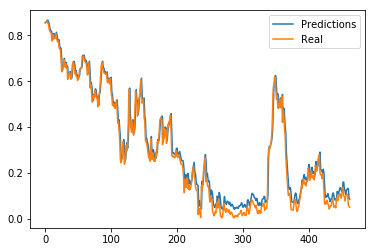

In [15]:

#print(closed_X_val.shape,Volume_X_val.shape,ema6_X_val.shape,ema12_X_val.shape,ema26_X_val.shape,macd_X_val.shape,wrsi_X_val.shape,K_X_val.shape,D_X_val.shape)
preds = merged_model.predict([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val])
r2score = r2_score(closed_Y_val,preds[8])
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
plt.plot(preds[8],label='Predictions')
plt.plot(closed_Y_val,label='Real')
plt.legend(loc='best')
plt.show()

In [16]:
his = history.history
"""
for k in his.keys():
    plt.title(k)
    plt.plot(his[k])
    plt.show()
"""

'\nfor k in his.keys():\n    plt.title(k)\n    plt.plot(his[k])\n    plt.show()\n'

Average Errors: 0.017016377208917487


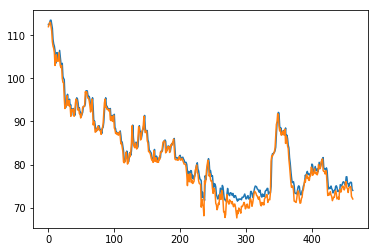

In [18]:
tt = preds
#because the closed price is at index 8, but the original data it's at index 0
tmp = np.array(tt[-1]).reshape(463,1)
for i in range(0,len(preds)-1):
    tt[i] = np.array(tt[i])
tt[0] = tmp
tt = np.array(tt).T.reshape(463,9)
t = pd.DataFrame(data=mms.inverse_transform(tt))
close_pre = np.array(t.loc[:,0].values)
close_val = np.array(pd.DataFrame(mms.inverse_transform(X_val_df.values)).loc[1:,0].values)
plt.plot(close_pre)
plt.plot(close_val)
print("Average Errors:",np.mean(np.abs(close_pre-close_val)/close_val))

In [19]:
prices= mms.inverse_transform(X_val[:-1])
#sr: spread rate
def ROR(preds,real,init_funds,period,sr=0.000,s=False):
    dict_Info = {
        'total_costs':[],
        'total_prices':[],
        'trade_times':[],
        'verbose':[],
        "RORs":[]
    }
    funds = init_funds
    profit=0
    total_cost=0
    total_price=0
    acc = []
    times = 0
    verbose = ''
    for i,p in enumerate(real):
        #print(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if preds[i]>prices[i][0] and (abs(preds[i]-prices[i][0])/prices[i][0]) > sr:
            times +=1
            quantity = int(funds / preds[i])
            total_cost += prices[i][0] * quantity
            total_price += p * quantity
            funds += (p-prices[i][0]) * quantity
            verbose += "\nBuy Date: {} - {}\nPrediction: {}\nReal Price: {}\nSpread: {}\n".format(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if (i+1)%period==0:
            #pass and not record the rate of prediciotn 'pre' < rate of threshold 'r'
            if total_cost != 0:
                dict_Info['total_costs'].append(total_cost*1000)
                dict_Info['total_prices'].append(total_price*1000)
                dict_Info['trade_times'].append(times)
                dict_Info['verbose'].append(verbose)
                dict_Info['RORs'].append((funds)/init_funds)
            times=0
            funds = init_funds
            total_cost=0
            total_price=0
            verbose = ''
    if times!=0:
        dict_Info['total_costs'].append(total_cost*1000)
        dict_Info['total_prices'].append(total_price*1000)
        dict_Info['trade_times'].append(times)
        dict_Info['verbose'].append(verbose)
        dict_Info['RORs'].append((funds)/init_funds*0.99575)
    return dict_Info,init_funds

In [20]:
d,funds = ROR(close_pre,close_val,1000,20*12)
for i in range(len(d['total_prices'])):
    msg = 'Total Costs: {}\nInitial Funds: {}\nProfits: {}\nReturn Of Rate: {}\n'.format(d['total_costs'][i],
                                                                                    funds*1000,
                                                                                     (d['total_prices'][i]-d['total_costs'][i])*0.99575,
                                                                                     d['RORs'][i])
    print(d['verbose'][i])
    print(msg)
print("Average of Yearly ROI: {:.3f}".format(np.mean(d['RORs'])))


Buy Date: ['106/10/31'] - 112.0
Prediction: 112.5
Real Price: 112.0
Spread: 0.0

Buy Date: ['106/11/01'] - 112.0
Prediction: 112.5
Real Price: 112.5
Spread: 0.5

Buy Date: ['106/11/02'] - 112.5
Prediction: 113.0
Real Price: 113.0
Spread: 0.5

Buy Date: ['106/11/03'] - 113.0
Prediction: 113.5
Real Price: 113.0
Spread: 0.0

Buy Date: ['106/11/06'] - 113.0
Prediction: 113.5
Real Price: 112.0
Spread: -1.0

Buy Date: ['106/11/07'] - 112.0
Prediction: 112.5
Real Price: 111.0
Spread: -1.0

Buy Date: ['106/11/08'] - 111.0
Prediction: 111.60621643066406
Real Price: 108.5
Spread: -2.5

Buy Date: ['106/11/09'] - 108.5
Prediction: 109.0
Real Price: 107.5
Spread: -1.0

Buy Date: ['106/11/10'] - 107.5
Prediction: 108.0
Real Price: 107.0
Spread: -0.5

Buy Date: ['106/11/13'] - 107.0
Prediction: 107.5
Real Price: 106.0
Spread: -1.0

Buy Date: ['106/11/14'] - 106.0
Prediction: 106.5
Real Price: 103.0
Spread: -3.0

Buy Date: ['106/11/15'] - 103.0
Prediction: 103.5
Real Price: 104.0
Spread: 1.0

Buy Dat

In [21]:
print(dates_val)

[['106/10/31']
 ['106/11/01']
 ['106/11/02']
 ['106/11/03']
 ['106/11/06']
 ['106/11/07']
 ['106/11/08']
 ['106/11/09']
 ['106/11/10']
 ['106/11/13']
 ['106/11/14']
 ['106/11/15']
 ['106/11/16']
 ['106/11/17']
 ['106/11/20']
 ['106/11/21']
 ['106/11/22']
 ['106/11/23']
 ['106/11/24']
 ['106/11/27']
 ['106/11/28']
 ['106/11/29']
 ['106/11/30']
 ['106/12/01']
 ['106/12/04']
 ['106/12/05']
 ['106/12/06']
 ['106/12/07']
 ['106/12/08']
 ['106/12/11']
 ['106/12/12']
 ['106/12/13']
 ['106/12/14']
 ['106/12/15']
 ['106/12/18']
 ['106/12/19']
 ['106/12/20']
 ['106/12/21']
 ['106/12/22']
 ['106/12/25']
 ['106/12/26']
 ['106/12/27']
 ['106/12/28']
 ['106/12/29']
 ['107/01/02']
 ['107/01/03']
 ['107/01/04']
 ['107/01/05']
 ['107/01/08']
 ['107/01/09']
 ['107/01/10']
 ['107/01/11']
 ['107/01/12']
 ['107/01/15']
 ['107/01/16']
 ['107/01/17']
 ['107/01/18']
 ['107/01/19']
 ['107/01/22']
 ['107/01/23']
 ['107/01/24']
 ['107/01/25']
 ['107/01/26']
 ['107/01/29']
 ['107/01/30']
 ['107/01/31']
 ['107/02/